# Defender Player Analysis

Continue the player analysis by position, this time looking at defenders. Based on the analysis for forwards and midfielders, the method of remapping points proves the most sensible approach. Therefore, I will only use the points remap method for this analysis and I will rank the top 20 defenders by mean (total - bonus pts).

* **Points Remap Method:** Take this season's defenders, and map their stats over the last 3 seasons to the points they would've scored if they were a defender. This will require me to discard bonus points as these are scored differently per position and depend on the bps scored by all other players in the fixture. At this point, that is too complicated to account for. This method takes into account the fact that players may move around positions in FPL between seasons.

I will then carry out the usual statistical test and add information on price and average opposition team strength this season.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from statsmodels.stats.multitest import multipletests
from IPython.display import display_html
from IPython.display import HTML
from convert_points import convert_points

# Read and pre-process data

## 2023/24 data

In [2]:
path_2023_24 = '../data/Fantasy-Premier-League/data/2023-24/gws/merged_gw.csv'
data_2023_24 = pd.read_csv(path_2023_24, low_memory = False)
data_2023_24.loc[:,'total - bonus points'] = data_2023_24.total_points - data_2023_24.bonus
DEFs_2023_24 = data_2023_24.loc[data_2023_24.position == 'DEF', 'name'].unique()
data_2023_24

,name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,total - bonus points
0,Femi Seriki,DEF,Sheffield Utd,0.5,0,0,0,0,0.0,653,...,0.0,0,0,0,0,40,True,0,1,0
1,Jack Hinshelwood,MID,Brighton,1.5,0,0,0,0,0.0,621,...,0.0,0,0,0,0,45,True,0,1,0
2,Jadon Sancho,MID,Man Utd,3.0,0,0,4,0,11.3,397,...,8.0,1,0,0,0,70,True,0,1,1
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.1,0,0,0,0,0.0,487,...,0.0,0,0,0,0,40,True,0,1,0
4,Vitaly Janelt,MID,Brentford,2.1,0,0,6,0,11.5,105,...,17.0,2,0,0,0,55,True,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,Jacob Brown,FWD,Luton,3.1,0,0,3,0,1.9,631,...,2.0,2,3299,5014,1715,49,False,0,7,2
4876,Jacob Brown,FWD,Luton,3.1,0,0,4,0,30.5,631,...,20.0,1,3299,5014,1715,49,True,1,7,1
4877,Vicente Guaita,GK,Crystal Palace,0.0,0,0,0,0,0.0,227,...,0.0,0,-4521,0,4521,44,False,0,7,0
4878,Braian Ojeda Rodríguez,MID,Nott'm Forest,0.0,0,0,0,0,0.0,459,...,0.0,0,-13,0,13,45,True,0,7,0


## 2020/21 - 2022/23 data

In [3]:
data_2020_23_path = '../data/Fantasy-Premier-League/data/cleaned_merged_seasons.csv'
seasons_df = pd.read_csv(data_2020_23_path, low_memory = False)
seasons = ['2020-21', '2021-22', '2022-23']
data_2020_23_df = seasons_df.loc[seasons_df.season_x.isin(seasons),:]
data_2020_23_df.position = data_2020_23_df.position.map({'DEF':'DEF','FWD':'FWD','GK':'GK','GKP':'GK','MID':'MID'})
DEFs_2020_23_data = data_2020_23_df.loc[data_2020_23_df.name.isin(DEFs_2023_24),:]
DEFs_2020_23_data.loc[:,'total - bonus points'] = DEFs_2020_23_data.total_points - DEFs_2020_23_data.bonus
DEFs_2020_23_data

C:\Users\Development\AppData\Local\Temp\ipykernel_15416\2380694436.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2020_23_df.position = data_2020_23_df.position.map({'DEF':'DEF','FWD':'FWD','GK':'GK','GKP':'GK','MID':'MID'})
C:\Users\Development\AppData\Local\Temp\ipykernel_15416\2380694436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DEFs_2020_23_data.loc[:,'total - bonus points'] = DEFs_2020_23_data.total_points - DEFs_2020_23_data.bonus


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW,total - bonus points
19853,2020-21,Aaron Cresswell,DEF,West Ham,0,0,11,0,11.2,435,...,0.0,1,0,0,0,50,True,0,1,1
19861,2020-21,Adam Webster,DEF,Brighton,0,0,14,0,11.8,66,...,1.0,1,0,0,0,45,True,0,1,1
19880,2020-21,Andrew Robertson,DEF,Liverpool,1,0,20,0,19.6,255,...,4.0,4,0,0,0,70,True,0,1,4
19886,2020-21,Angelo Ogbonna,DEF,West Ham,0,0,14,0,1.1,432,...,6.0,1,0,0,0,50,True,0,1,1
19890,2020-21,Antonee Robinson,DEF,Fulham,0,0,0,0,0.0,484,...,0.0,0,0,0,0,45,True,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96148,2022-23,Gabriel dos Santos Magalhães,DEF,Arsenal,0,0,25,1,0.0,16,...,0.0,6,52844,70075,17231,52,True,0,38,6
96150,2022-23,Emerson Palmieri dos Santos,DEF,West Ham,0,0,5,0,0.0,545,...,0.0,1,-3121,750,3871,40,False,0,38,1
96154,2022-23,Ethan Pinnock,DEF,Brentford,0,3,49,1,0.0,92,...,0.0,15,-2147,2602,4749,44,True,0,38,12
96165,2022-23,Ryan Sessegnon,DEF,Spurs,0,0,0,0,0.0,436,...,0.0,0,-166,24,190,44,False,0,38,0


# Points Remap

Map the stats from all of this season's DEFs from 2020 - 2023 to the points they would've scored if they were a defender. Sum across the columns to get total - bonus points.

## Re-map the points

In [4]:
Remap_DEFs_2020_2023 = DEFs_2020_23_data.loc[:, ['name', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'saves',
                          'penalties_saved', 'penalties_missed', 'goals_conceded', 'yellow_cards',
                          'red_cards', 'own_goals']]
Remap_DEFs_2020_2023 = convert_points('DEF', Remap_DEFs_2020_2023)
Remap_DEFs_2020_2023['total - bonus points'] =  Remap_DEFs_2020_2023.drop(columns=['name']).sum(axis=1)
Remap_DEFs_2020_2023

,name,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,penalties_missed,goals_conceded,yellow_cards,red_cards,own_goals,total - bonus points
19853,Aaron Cresswell,2,0,0,0,0,0,0,-1,0,0,0,1
19861,Adam Webster,2,0,0,0,0,0,0,-1,0,0,0,1
19880,Andrew Robertson,2,0,3,0,0,0,0,-1,0,0,0,4
19886,Angelo Ogbonna,2,0,0,0,0,0,0,-1,0,0,0,1
19890,Antonee Robinson,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96148,Gabriel dos Santos Magalhães,2,0,0,4,0,0,0,0,0,0,0,6
96150,Emerson Palmieri dos Santos,1,0,0,0,0,0,0,0,0,0,0,1
96154,Ethan Pinnock,2,6,0,4,0,0,0,0,0,0,0,12
96165,Ryan Sessegnon,0,0,0,0,0,0,0,0,0,0,0,0


## Which players had the highest mean points after the remapping?

In [5]:
top_20_DEFs_mean = Remap_DEFs_2020_2023.loc[:, ['name','total - bonus points']].groupby(['name']).mean()
top_20_DEFs_mean.sort_values(by='total - bonus points',ascending=False,inplace=True)
top_20_DEFs_mean = top_20_DEFs_mean.iloc[0:20]
top_20_DEFs_mean = top_20_DEFs_mean.rename(columns={'total - bonus points':'total - bonus pts mean'})
top_20_DEFs_mean

,total - bonus pts mean
name,
Trent Alexander-Arnold,3.903509
Benjamin White,3.789474
Andrew Robertson,3.649123
Gabriel dos Santos Magalhães,3.447368
Alexandre Moreno Lopera,3.350000
Kieran Trippier,3.228070
Sven Botman,3.184211
Pedro Porro,3.176471
Pervis Estupiñán,3.138889


In [6]:
top_20_DEFs_names = list(top_20_DEFs_mean.index)
top_20_DEFs_names

['Trent Alexander-Arnold',
 'Benjamin White',
 'Andrew Robertson',
 'Gabriel dos Santos Magalhães',
 'Alexandre Moreno Lopera',
 'Kieran Trippier',
 'Sven Botman',
 'Pedro Porro',
 'Pervis Estupiñán',
 'Tyrone Mings',
 'Rico Henry',
 'Marc Guéhi',
 'Lewis Dunk',
 'Virgil van Dijk',
 'Ben Mee',
 'Aaron Cresswell',
 'Eric Dier',
 'Ezri Konsa Ngoyo',
 'Joachim Andersen',
 'Ethan Pinnock']

## How many games did they play?

In [7]:
matches_played = DEFs_2020_23_data.loc[:,['name','GW']].groupby('name').size()
matches_played = matches_played.loc[top_20_DEFs_names]
matches_played.name = 'GWs played'
top_20_DEFs_mean = top_20_DEFs_mean.join(matches_played)
top_20_DEFs_mean

,total - bonus pts mean,GWs played
name,,
Trent Alexander-Arnold,3.903509,114
Benjamin White,3.789474,38
Andrew Robertson,3.649123,114
Gabriel dos Santos Magalhães,3.447368,38
Alexandre Moreno Lopera,3.350000,20
Kieran Trippier,3.228070,57
Sven Botman,3.184211,38
Pedro Porro,3.176471,17
Pervis Estupiñán,3.138889,36


## Extract points data for each of these players and generate boxplots:

In [8]:
points_data = []
for name in top_20_DEFs_names:
    points_data.append(Remap_DEFs_2020_2023.loc[Remap_DEFs_2020_2023.name == name,'total - bonus points'].values.astype(float))

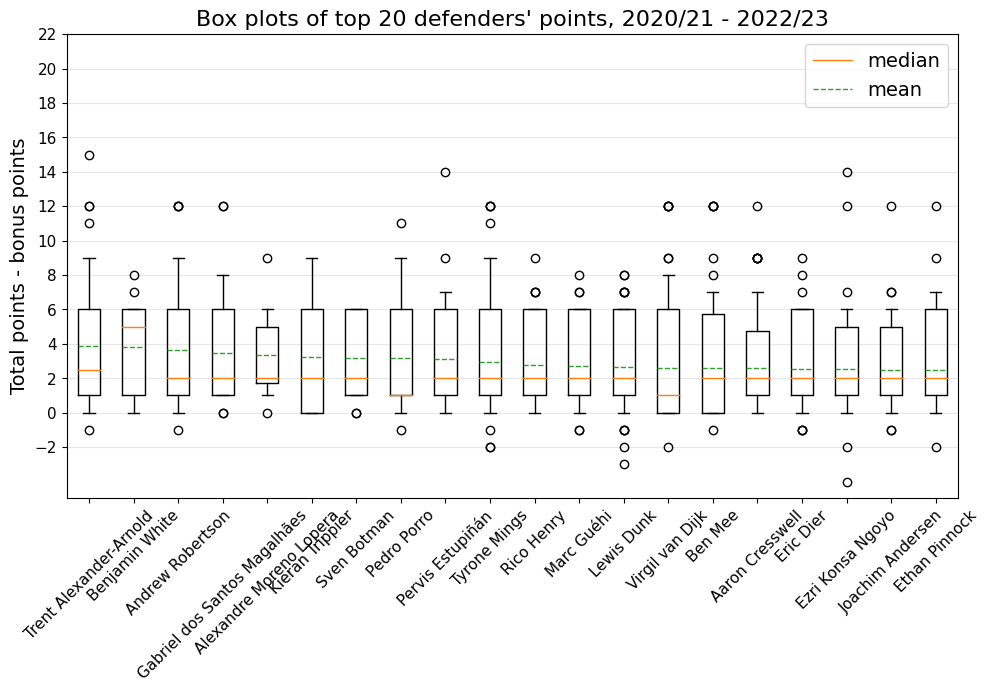

In [9]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,7))
box_dict = ax.boxplot(points_data, whis=(5,95), labels = top_20_DEFs_names, meanline = True, showmeans = True)
_ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = axis_tick_font, rotation = 45)
_ = ax.set_yticks(np.arange(-2,24,2))
_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize = axis_tick_font)
ax.set_ylabel('Total points - bonus points', fontsize = axis_label_font)
ax.grid(axis = 'y', alpha = 0.3)
ax.legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax.set_title('''Box plots of top 20 defenders' points, 2020/21 - 2022/23''', fontsize = axis_title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/top_20_DEFs_boxplots.png', bbox_inches = 'tight')
plt.show()

# What's their performance like this season so far?

## Preprocessing before analysis:

First let's rename and reorder columns, then calculate standard deviation of total - bonus points.

In [10]:
top_20_DEFs_mean.rename(columns={'total - bonus pts mean':'mean total - bonus 2020 - 2023',
                                 'GWs played': 'GWs played 2020-2023'}, inplace = True)
top_20_DEFs_mean = top_20_DEFs_mean[['GWs played 2020-2023', 'mean total - bonus 2020 - 2023']]
# Standard deviation of remapped points:
pts_std = Remap_DEFs_2020_2023.loc[:,['name','total - bonus points']].groupby(['name']).std()
pts_std.rename(columns = {'total - bonus points':'Std total - bonus 2020 - 2023'},inplace = True)
top_20_DEFs_mean = top_20_DEFs_mean.join(pts_std, how='left')
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023
name,,,
Trent Alexander-Arnold,114,3.903509,3.274923
Benjamin White,38,3.789474,2.440180
Andrew Robertson,114,3.649123,3.114290
Gabriel dos Santos Magalhães,38,3.447368,3.064155
Alexandre Moreno Lopera,20,3.350000,2.390221
Kieran Trippier,57,3.228070,3.006051
Sven Botman,38,3.184211,2.264357
Pedro Porro,17,3.176471,3.574830
Pervis Estupiñán,36,3.138889,3.172676


## Join 2023/24 season data:

In [11]:
mean_pts_2023_24 = data_2023_24.loc[data_2023_24.name.isin(top_20_DEFs_names),['name',\
                                    'total - bonus points']].groupby(['name']).mean()
mean_pts_2023_24.rename(columns={'total - bonus points':'mean total - bonus 2023-24'}, inplace = True)
top_20_DEFs_mean = top_20_DEFs_mean.join(mean_pts_2023_24, how = 'left')
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24
name,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000
Benjamin White,38,3.789474,2.440180,4.571429
Andrew Robertson,114,3.649123,3.114290,3.142857
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000
Kieran Trippier,57,3.228070,3.006051,5.000000
Sven Botman,38,3.184211,2.264357,3.714286
Pedro Porro,17,3.176471,3.574830,3.285714
Pervis Estupiñán,36,3.138889,3.172676,2.857143


## Statistical Test

We want to see if there's a statistically significant difference in the performance of these players this season (so far). That is, we want to say with a 95% confidence that there is an effect present in the data causing the change in performance. We cannot say what this effect is - i.e. is it because these players have played a sequence of easy or hard teams so far? Are they playing out of position? We can only say that an effect exists, and we will factor this into our eventual drafting decisions.

To this end:
* We will calculate the effect size - this shows how large the deviation in performance is this season compared to the last 3 seasons.
* We will carry out a 1-sided t-test for the mean total - bonus points. We consider the 3 previous seasons from 2020/21 - 2022/23 to be our population data: we have all the data from these seasons, not just a sample of a handful of games. We will compare this to our "sample" this season: the GWs that have been played so far. A 1-sided test will be used because we care about the "direction" of the change, i.e. we care not just that it changed, but did it increase or decrease?
* We will then use the Benjamini-Hochberg procedure to limit the False Discovery Rate (FDR) to 5% - as we are carrying out 20 tests, we want to be sure we're not measuring an effect due to sampling chance.

### Effect Size

We will use Cohen's d to measure effect size.

In [12]:
top_20_DEFs_mean['Effect size'] = (top_20_DEFs_mean['mean total - bonus 2023-24'] - \
                                   top_20_DEFs_mean['mean total - bonus 2020 - 2023'])\
                                    /top_20_DEFs_mean['Std total - bonus 2020 - 2023']
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size
name,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000,-0.581238
Benjamin White,38,3.789474,2.440180,4.571429,0.320450
Andrew Robertson,114,3.649123,3.114290,3.142857,-0.162562
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714,-0.379111
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000,-1.401544
Kieran Trippier,57,3.228070,3.006051,5.000000,0.589454
Sven Botman,38,3.184211,2.264357,3.714286,0.234095
Pedro Porro,17,3.176471,3.574830,3.285714,0.030559
Pervis Estupiñán,36,3.138889,3.172676,2.857143,-0.088804


### 1-sided t-test

$H_0$ $:$ mean points 2023/24 season - mean points 2020/21 - 2022/23 = 0

$H_A$ $:$ mean points 2023/24 season > mean points 2020/21 - 2022/23 **OR** mean points 2023/24 season < mean points 2020/21 - 2022/23
(depending on the change)

In [13]:
top_20_DEFs_mean['n'] = data_2023_24['GW'].max() # Sample size
top_20_DEFs_mean['SE'] = top_20_DEFs_mean['Std total - bonus 2020 - 2023']/np.sqrt(top_20_DEFs_mean['n'])
top_20_DEFs_mean['t'] = (top_20_DEFs_mean['mean total - bonus 2023-24'] - \
                        top_20_DEFs_mean['mean total - bonus 2020 - 2023'])/top_20_DEFs_mean['SE']
top_20_DEFs_mean['p-value'] = t.sf(np.abs(top_20_DEFs_mean['t'].values), top_20_DEFs_mean['n'].values-1)
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value
name,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000,-0.581238,7,1.237805,-1.537810,0.087506
Benjamin White,38,3.789474,2.440180,4.571429,0.320450,7,0.922302,0.847830,0.214526
Andrew Robertson,114,3.649123,3.114290,3.142857,-0.162562,7,1.177091,-0.430099,0.341071
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714,-0.379111,7,1.158142,-1.003033,0.177283
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000,-1.401544,7,0.903419,-3.708137,0.004996
Kieran Trippier,57,3.228070,3.006051,5.000000,0.589454,7,1.136180,1.559550,0.084941
Sven Botman,38,3.184211,2.264357,3.714286,0.234095,7,0.855846,0.619358,0.279225
Pedro Porro,17,3.176471,3.574830,3.285714,0.030559,7,1.351159,0.080852,0.469095
Pervis Estupiñán,36,3.138889,3.172676,2.857143,-0.088804,7,1.199159,-0.234953,0.411029


### Benjamini-Hochberg Procedure

Control the false discovery rate (FDR) to 5%. We will not record the new p-values - just whether the null hypothesis is rejected or not i.e. whether the result is statistically significant.

In [14]:
top_20_DEFs_mean['BH Statistically Significant'], _, _, _ = multipletests(top_20_DEFs_mean['p-value'].values, 
                                                                alpha=0.05, 
                                                                method='fdr_bh',
                                                                is_sorted=False, 
                                                                returnsorted=False)
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant
name,,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000,-0.581238,7,1.237805,-1.537810,0.087506,False
Benjamin White,38,3.789474,2.440180,4.571429,0.320450,7,0.922302,0.847830,0.214526,False
Andrew Robertson,114,3.649123,3.114290,3.142857,-0.162562,7,1.177091,-0.430099,0.341071,False
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714,-0.379111,7,1.158142,-1.003033,0.177283,False
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000,-1.401544,7,0.903419,-3.708137,0.004996,False
Kieran Trippier,57,3.228070,3.006051,5.000000,0.589454,7,1.136180,1.559550,0.084941,False
Sven Botman,38,3.184211,2.264357,3.714286,0.234095,7,0.855846,0.619358,0.279225,False
Pedro Porro,17,3.176471,3.574830,3.285714,0.030559,7,1.351159,0.080852,0.469095,False
Pervis Estupiñán,36,3.138889,3.172676,2.857143,-0.088804,7,1.199159,-0.234953,0.411029,False


### Effect Size Label:

In [15]:
top_20_DEFs_mean['Effect size label'] = np.digitize(np.abs(top_20_DEFs_mean['Effect size']), [0.01,0.2,0.5,0.8,1.20,2.0],
                                                   right = True)
top_20_DEFs_mean['Effect size label'] = top_20_DEFs_mean['Effect size label'].map({0:'None',1:'Very small',2:'Small',
                                                                                   3:'Medium',4:'Large',5:'Very large',
                                                                                   6:'Huge'})
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant,Effect size label
name,,,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000,-0.581238,7,1.237805,-1.537810,0.087506,False,Medium
Benjamin White,38,3.789474,2.440180,4.571429,0.320450,7,0.922302,0.847830,0.214526,False,Small
Andrew Robertson,114,3.649123,3.114290,3.142857,-0.162562,7,1.177091,-0.430099,0.341071,False,Very small
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714,-0.379111,7,1.158142,-1.003033,0.177283,False,Small
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000,-1.401544,7,0.903419,-3.708137,0.004996,False,Very large
Kieran Trippier,57,3.228070,3.006051,5.000000,0.589454,7,1.136180,1.559550,0.084941,False,Medium
Sven Botman,38,3.184211,2.264357,3.714286,0.234095,7,0.855846,0.619358,0.279225,False,Small
Pedro Porro,17,3.176471,3.574830,3.285714,0.030559,7,1.351159,0.080852,0.469095,False,Very small
Pervis Estupiñán,36,3.138889,3.172676,2.857143,-0.088804,7,1.199159,-0.234953,0.411029,False,Very small


### Statistical Test Conclusion

We fail to reject the null hypothesis $H_0$ for all 20 players after applying the Benjamini Hochberg procedure, meaning the performance deviation of these players is not statistically significant. It may be the case for some players that their performance actually hasn't changed at all, whereas for others, it may be due to chance in the sample of games they've played so far.

# Additional Stats for 2023/24 season

Price, and average rank of opponent teams so far are important metrics to analyse when drafting players.

## Add price column

In [16]:
latest_GW = data_2023_24.GW.max()
current_price_df = data_2023_24.loc[(data_2023_24.GW == latest_GW) & (data_2023_24.name.isin(top_20_DEFs_names)), 
                                    ['name','value']]
current_price_df.set_index('name',inplace=True)
current_price_df.value /= 10 # get price in millions
current_price_df.rename(columns={'value':'Current Price (M)'}, inplace=True)
top_20_DEFs_mean = top_20_DEFs_mean.join(current_price_df, how='left')
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,mean total - bonus 2023-24,Effect size,n,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M)
name,,,,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,2.000000,-0.581238,7,1.237805,-1.537810,0.087506,False,Medium,7.9
Benjamin White,38,3.789474,2.440180,4.571429,0.320450,7,0.922302,0.847830,0.214526,False,Small,5.5
Andrew Robertson,114,3.649123,3.114290,3.142857,-0.162562,7,1.177091,-0.430099,0.341071,False,Very small,6.6
Gabriel dos Santos Magalhães,38,3.447368,3.064155,2.285714,-0.379111,7,1.158142,-1.003033,0.177283,False,Small,4.7
Alexandre Moreno Lopera,20,3.350000,2.390221,0.000000,-1.401544,7,0.903419,-3.708137,0.004996,False,Very large,5.0
Kieran Trippier,57,3.228070,3.006051,5.000000,0.589454,7,1.136180,1.559550,0.084941,False,Medium,6.7
Sven Botman,38,3.184211,2.264357,3.714286,0.234095,7,0.855846,0.619358,0.279225,False,Small,4.7
Pedro Porro,17,3.176471,3.574830,3.285714,0.030559,7,1.351159,0.080852,0.469095,False,Very small,5.0
Pervis Estupiñán,36,3.138889,3.172676,2.857143,-0.088804,7,1.199159,-0.234953,0.411029,False,Very small,5.3


## Add mean opposition strength column

In [17]:
team_data_path = '../data/Fantasy-Premier-League/data/2023-24/teams.csv'
team_data = pd.read_csv(team_data_path)
team_id_rank_map = dict(zip(team_data.id, team_data.strength)) # Create map between team id and strength

In [18]:
avg_team_rank = data_2023_24.loc[data_2023_24.name.isin(top_20_DEFs_names), ['name','opponent_team']]
avg_team_rank.opponent_team = avg_team_rank.opponent_team.map(team_id_rank_map)
avg_team_rank = avg_team_rank.groupby('name').mean()
avg_team_rank.rename(columns = {'opponent_team': 'Average opposition strength 2023/24'}, inplace=True)
top_20_DEFs_mean = top_20_DEFs_mean.join(avg_team_rank, how='left')
top_20_DEFs_mean.rename(columns = {'n': 'GWs played 2023-24'}, inplace=True)
top_20_DEFs_mean = top_20_DEFs_mean[['GWs played 2020-2023','mean total - bonus 2020 - 2023',
                                     'Std total - bonus 2020 - 2023',
                                     'GWs played 2023-24','mean total - bonus 2023-24',
                                     'Effect size',
                                     'SE','t','p-value','BH Statistically Significant',
                                     'Effect size label','Current Price (M)','Average opposition strength 2023/24']]
top_20_DEFs_mean

,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,GWs played 2023-24,mean total - bonus 2023-24,Effect size,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M),Average opposition strength 2023/24
name,,,,,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,7,2.000000,-0.581238,1.237805,-1.537810,0.087506,False,Medium,7.9,3.142857
Benjamin White,38,3.789474,2.440180,7,4.571429,0.320450,0.922302,0.847830,0.214526,False,Small,5.5,3.142857
Andrew Robertson,114,3.649123,3.114290,7,3.142857,-0.162562,1.177091,-0.430099,0.341071,False,Very small,6.6,3.142857
Gabriel dos Santos Magalhães,38,3.447368,3.064155,7,2.285714,-0.379111,1.158142,-1.003033,0.177283,False,Small,4.7,3.142857
Alexandre Moreno Lopera,20,3.350000,2.390221,7,0.000000,-1.401544,0.903419,-3.708137,0.004996,False,Very large,5.0,3.142857
Kieran Trippier,57,3.228070,3.006051,7,5.000000,0.589454,1.136180,1.559550,0.084941,False,Medium,6.7,3.142857
Sven Botman,38,3.184211,2.264357,7,3.714286,0.234095,0.855846,0.619358,0.279225,False,Small,4.7,3.142857
Pedro Porro,17,3.176471,3.574830,7,3.285714,0.030559,1.351159,0.080852,0.469095,False,Very small,5.0,3.142857
Pervis Estupiñán,36,3.138889,3.172676,7,2.857143,-0.088804,1.199159,-0.234953,0.411029,False,Very small,5.3,3.142857


# Style table

In [19]:
def points_change(x):
    c1 = '''color:white;background-color: forestgreen '''
    c2 = '''color:white;background-color: crimson '''
    #compare columns
    mask = x['Effect size'] > 0
    mask2 = x['Effect size'] < 0
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    #modify values of df1 column by boolean mask
    df1.loc[mask, 'mean total - bonus 2023-24'] = c1
    df1.loc[mask2, 'mean total - bonus 2023-24'] = c2
    
    return df1

def effect_size_colour(x):
    a = sns.color_palette('BuGn',7).as_hex()
    
    none = f'''color:black;background-color: {a[0]} '''
    vsmall = f'''color:white;background-color: {a[1]} '''
    small = f'''color:white;background-color: {a[2]} '''
    med = f'''color:white;background-color: {a[3]} '''
    large = f'''color:white;background-color: {a[4]} '''
    vlarge = f'''color:white;background-color: {a[5]} '''
    huge = f'''color:white;background-color: {a[6]} '''
    #compare columns
    mask = x['Effect size label'] == 'None'
    mask2= x['Effect size label'] == 'Very small'
    mask3= x['Effect size label'] == 'Small'
    mask4= x['Effect size label'] == 'Medium'
    mask5= x['Effect size label'] == 'Large'
    mask6= x['Effect size label'] == 'Very large'
    mask7= x['Effect size label'] == 'Huge'
    #DataFrame with same index and columns names as original filled empty strings
    df1 =  pd.DataFrame('', index=x.index, columns=x.columns)
    #modify values of df1 column by boolean mask
    df1.loc[mask, 'Effect size label'] = none
    df1.loc[mask2, 'Effect size label'] = vsmall
    df1.loc[mask3, 'Effect size label'] = small
    df1.loc[mask4, 'Effect size label'] = med
    df1.loc[mask5, 'Effect size label'] = large
    df1.loc[mask6, 'Effect size label'] = vlarge
    df1.loc[mask7, 'Effect size label'] = huge
    
    return df1

In [20]:
highlight_slice = ['mean total - bonus 2020 - 2023','Current Price (M)']
top_20_DEFs_mean.style.set_properties(**{'color':'black','background-color': '#ffffb3'}, subset=highlight_slice)\
.background_gradient(cmap=sns.diverging_palette(145, 10, as_cmap=True), subset=['Average opposition strength 2023/24'])\
.applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\
.apply(points_change, axis=None)\
.apply(effect_size_colour, axis=None)

C:\Users\Development\AppData\Local\Temp\ipykernel_15416\3548902131.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\


,GWs played 2020-2023,mean total - bonus 2020 - 2023,Std total - bonus 2020 - 2023,GWs played 2023-24,mean total - bonus 2023-24,Effect size,SE,t,p-value,BH Statistically Significant,Effect size label,Current Price (M),Average opposition strength 2023/24
name,,,,,,,,,,,,,
Trent Alexander-Arnold,114,3.903509,3.274923,7,2.000000,-0.581238,1.237805,-1.537810,0.087506,False,Medium,7.900000,3.142857
Benjamin White,38,3.789474,2.440180,7,4.571429,0.320450,0.922302,0.847830,0.214526,False,Small,5.500000,3.142857
Andrew Robertson,114,3.649123,3.114290,7,3.142857,-0.162562,1.177091,-0.430099,0.341071,False,Very small,6.600000,3.142857
Gabriel dos Santos Magalhães,38,3.447368,3.064155,7,2.285714,-0.379111,1.158142,-1.003033,0.177283,False,Small,4.700000,3.142857
Alexandre Moreno Lopera,20,3.350000,2.390221,7,0.000000,-1.401544,0.903419,-3.708137,0.004996,False,Very large,5.000000,3.142857
Kieran Trippier,57,3.228070,3.006051,7,5.000000,0.589454,1.136180,1.559550,0.084941,False,Medium,6.700000,3.142857
Sven Botman,38,3.184211,2.264357,7,3.714286,0.234095,0.855846,0.619358,0.279225,False,Small,4.700000,3.142857
Pedro Porro,17,3.176471,3.574830,7,3.285714,0.030559,1.351159,0.080852,0.469095,False,Very small,5.000000,3.142857
Pervis Estupiñán,36,3.138889,3.172676,7,2.857143,-0.088804,1.199159,-0.234953,0.411029,False,Very small,5.300000,3.142857


In [21]:
highlight_slice = ['mean total - bonus 2020 - 2023','Current Price (M)']
top_20_DEFs_mean.style.set_properties(**{'color':'black','background-color': '#ffffb3'}, subset=highlight_slice)\
.background_gradient(cmap=sns.diverging_palette(145, 10, as_cmap=True), subset=['Average opposition strength 2023/24'])\
.applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\
.apply(points_change, axis=None)\
.apply(effect_size_colour, axis=None).to_excel('./results/Defenders_analysis.xlsx', engine='openpyxl')

C:\Users\Development\AppData\Local\Temp\ipykernel_15416\2108402551.py:4: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: f'''color:white;background-color: {'forestgreen' if x else 'crimson'}''',subset=['BH Statistically Significant'])\


# Summary and Conclusion

I analysed the top 20 defenders from the past 3 seasons (2020/21 - 2022/23) using the points remap method.

I then compared their performance so far this season (2023/24). I calculated the effect size, to measure how big the deviation is, and then carried out a 1 sided t-test to determine if the deviation is statistically significant. After applying the Benjamini Hochberg procedure to control the FDR to 5%, I found that the differences were not statistically significant for any player.

Finally, I added some information on the current price of the players and their average opposition rank this season (which may help explain performance deviations), before styling the results table and exporting to Excel.

I intend to use these results, as well as the results for the other positions to compile my team after playing the wild card chip.